# Modeling and Evaluation

## Objectives

* Fit and evaluate a classification model to predict the sale price of houses


# Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

# Outputs

* Train set (features and target)
* Test set (features and target)
* Modeling pipeline
* Feature importance plot


***

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

# Load data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


# ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder

In [6]:
from feature_engine import transformation as vt
from feature_engine.selection import DropFeatures
from feature_engine.imputation import  MeanMedianImputer
from feature_engine.imputation import  CategoricalImputer
from feature_engine.imputation import  ArbitraryNumberImputer

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base


## ML Pipeline for Modelling and Hyperparameter Optimisation

In [7]:
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Code Institutes Custom Class for Hyperparameter Optimisation

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


Train and Test set seems to be balanced, so we dont need to handle any imbalance

Fit and transform train and test set

In [10]:
pipeline = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 17) (1168,) (292, 17) (292,)


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [11]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "XGBRegressor": XGBRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

In [12]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring = 'r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check for results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
4,GradientBoostingRegressor,0.643677,0.776681,0.826127,0.0675
5,ExtraTreesRegressor,0.682763,0.754073,0.786768,0.036548
3,RandomForestRegressor,0.618595,0.719973,0.787277,0.056429
6,AdaBoostRegressor,0.624003,0.707547,0.749044,0.049521
1,XGBRegressor,0.637822,0.67607,0.711843,0.027401
2,DecisionTreeRegressor,0.352005,0.557464,0.627322,0.104766
0,LogisticRegression,0.41619,0.502659,0.582253,0.069263


From the results we will be carrying out an extensive search on GradientBoostingReressor as it seems to be giving us the best results for hyperparameter configuration

## Extensive search on GradientBoostingReressor

We define models needed for extensive search

In [14]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {"GradientBoostingRegressor":{
       'model__learning_rate': [0.1, 0.07], 
        'model__max_depth': [5],
        'model__n_estimators': [50, 75],
        'model__min_samples_split': [50, 75],
        'model__min_samples_leaf': [25],
        'model__random_state': [None, 10],
        'model__subsample': [1.0, 0.8],
        'model__max_leaf_nodes': [None],
   }}

Extensive GridSearch CV

In [15]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = 'r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


We will check the results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__random_state,model__subsample
8,GradientBoostingRegressor,0.751164,0.81091,0.839904,0.035846,0.1,5,None,25,75,50,None,1.0
10,GradientBoostingRegressor,0.751164,0.81091,0.839904,0.035846,0.1,5,None,25,75,50,10,1.0
23,GradientBoostingRegressor,0.756529,0.810694,0.84356,0.03375,0.07,5,None,25,50,75,10,0.8
11,GradientBoostingRegressor,0.755881,0.810379,0.843445,0.03402,0.1,5,None,25,75,50,10,0.8
31,GradientBoostingRegressor,0.756439,0.810354,0.842758,0.032991,0.07,5,None,25,75,75,10,0.8
13,GradientBoostingRegressor,0.745281,0.81019,0.845268,0.038355,0.1,5,None,25,75,75,None,0.8
15,GradientBoostingRegressor,0.751367,0.810083,0.841907,0.034809,0.1,5,None,25,75,75,10,0.8
12,GradientBoostingRegressor,0.744441,0.810048,0.840092,0.037682,0.1,5,None,25,75,75,None,1.0
14,GradientBoostingRegressor,0.744441,0.810048,0.840092,0.037682,0.1,5,None,25,75,75,10,1.0
3,GradientBoostingRegressor,0.752866,0.809548,0.845306,0.035235,0.1,5,None,25,50,50,10,0.8


In [17]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Check best parameters for model

In [18]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 25,
 'model__min_samples_split': 75,
 'model__n_estimators': 50,
 'model__random_state': None,
 'model__subsample': 1.0}

Best clf pipeline

In [19]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=25,
                                           min_samples_split=75,
                                           n_estimators=50))])

# Assess feature importance

We will look find the most important features in the data

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF']


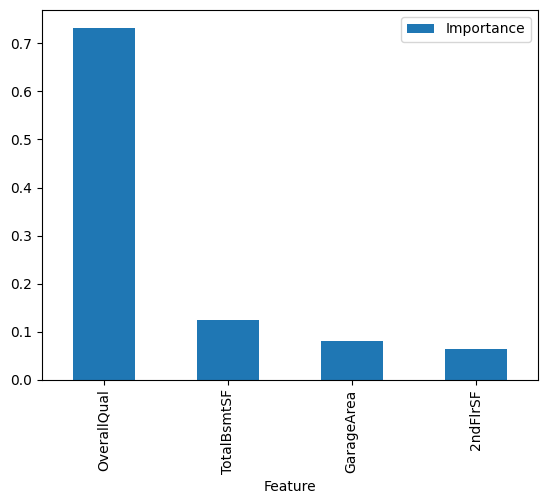

In [20]:
import matplotlib.pyplot as plt

df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


best_features = df_feature_importance['Feature'].to_list()


print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

# Evaluate Pipeline on Train and Test Sets

Measure how close regression line is to data points with mean and absolute error

In [21]:
from sklearn.metrics import mean_squared_error

predict = pipeline_clf.predict(X_train)
print("Mean squared error")
mean_squared_error(y_train, predict)

Mean squared error


866939152.4767833

In [22]:
from sklearn.metrics import mean_absolute_error

predict = pipeline_clf.predict(X_train)
print("Mean absolute error")
mean_absolute_error(y_train, predict)

Mean absolute error


19342.1257490966

In [23]:
from sklearn.metrics import r2_score

predict_test = pipeline_clf.predict(X_train)
r2_score(y_train, predict)

0.8591936400353658

It looks like the R2 score is good fit for our model

<AxesSubplot:ylabel='SalePrice'>

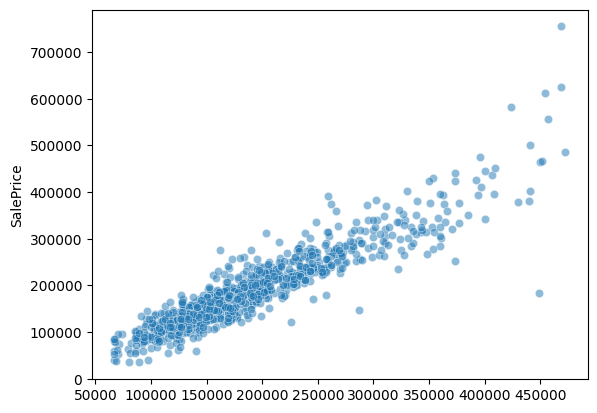

In [24]:
import seaborn as sns

sns.scatterplot(x=predict, y=y_train, alpha=0.5)

And the data seems to be following a line in the middle. There is some scattered dots, but for the most of the data it's in close proximity of line.

# Rewrite ML pipeline with the best features

In [25]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base

In [26]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

We only apply the best parameters

In [27]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {"GradientBoostingRegressor":{
       'model__learning_rate': [0.1], 
        'model__max_depth': [5],
        'model__n_estimators': [50],
        'model__min_samples_split': [75],
        'model__min_samples_leaf': [25],
        'model__random_state': [None],
        'model__subsample': [1.0],
        'model__max_leaf_nodes': [None],
   }}

In [28]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = 'r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [29]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__random_state,model__subsample
0,GradientBoostingRegressor,0.751164,0.81091,0.839904,0.035846,0.1,5,None,25,75,50,None,1.0


In [30]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 4) (1168,) (292, 4) (292,)


,OverallQual,TotalBsmtSF,GarageArea,2ndFlrSF
618,9,1822,285.045723,0.0
870,5,894,133.391173,0.0
92,5,876,176.329005,0.0


Now we know what the best features are we can write them in a pipeline

In [40]:
def SimplifiedPipelineEngineering():
    pipeline_smpl = Pipeline([
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['GarageArea'])),

    ])

    return pipeline_smpl

In [41]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

Again apply only the best parameters as previously

In [42]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {"GradientBoostingRegressor":{
       'model__learning_rate': [0.1], 
        'model__max_depth': [5],
        'model__n_estimators': [50],
        'model__min_samples_split': [75],
        'model__min_samples_leaf': [25],
        'model__random_state': [None],
        'model__subsample': [1.0],
        'model__max_leaf_nodes': [None],
   }}

In [43]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = 'r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check the result

In [44]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__random_state,model__subsample
0,GradientBoostingRegressor,0.751164,0.80696,0.839904,0.039137,0.1,5,None,25,75,50,None,1.0


/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

The simplified pipeline is similar to our previous pipeline with the most important variables and it also keeps a similar score

# Push the files to Repo

In [45]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_housing_price/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

In [46]:
print(X_train.shape)
X_train.head()

(1168, 4)


,OverallQual,TotalBsmtSF,GarageArea,2ndFlrSF
618,9,1822,285.045723,0.0
870,5,894,133.391173,0.0
92,5,876,176.329005,0.0
817,8,1568,309.970775,0.0
302,7,1541,305.798023,0.0


Save Train Set

In [47]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [48]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

Save Test Set

In [49]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [50]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Save Pipeline Model

In [53]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_housing_price/v1/clf_pipeline_model.pkl']

Save feature importance image

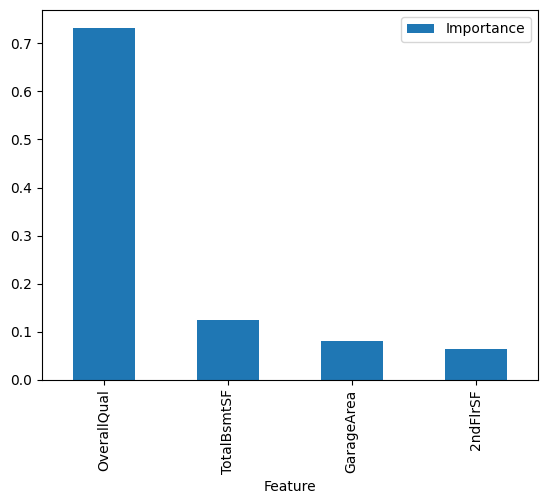

In [55]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')